In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

# Gene Nodes

Putting together the Information for the nodes and save them as a csv file.

Nodes are genes with the following information:
- Gene ID
- Gene Name
- TPM value for lung cancer
- TPM value for healthy lung tissue
- TMP difference between cancer and healthy tissue

In [15]:
df_gtex = pd.read_csv('../processed_data/GTEX_healthy_mean.csv')
df_cmp = pd.read_csv('../processed_data/CMP_cancer_mean.csv')

In [16]:
# rename columns
df_gtex.rename(columns={'tpm': 'healthy tpm'}, inplace=True)
df_cmp.rename(columns={'name': 'name',
                       'tpm': 'cancerous tpm'}, inplace=True)

## Cancer Datasets

In [17]:
df_nodes_cancer = df_cmp.copy()
print(f"There are {df_nodes_cancer.shape[0]} rows in the cancer dataset.")
df_nodes_cancer

There are 33502 rows in the cancer dataset.


,name,cancerous tpm,id
0,A1BG,0.827192,ENSG00000121410
1,A1BG-AS1,4.676305,ENSG00000268895
2,A1CF,1.355369,ENSG00000148584
3,A2M,1.669212,ENSG00000175899
4,A2M-AS1,1.033596,ENSG00000245105
...,...,...,...
33497,ZYG11AP1,0.000887,ENSG00000232242
33498,ZYG11B,21.124039,ENSG00000162378
33499,ZYXP1,0.000000,ENSG00000274572
33500,ZZEF1,17.697980,ENSG00000074755


## Merge with healthy

In [18]:
df_nodes_healthy = df_gtex.copy()

df_nodes_genes = df_nodes_cancer.merge(df_nodes_healthy, on='id', how='inner')

print(f"There are {df_nodes_genes.shape[0]} rows in the merged dataset. All have a healthy and a cancer tpm value.")

df_nodes_genes

There are 32865 rows in the merged dataset. All have a healthy and a cancer tpm value.


,name,cancerous tpm,id,healthy tpm
0,A1BG,0.827192,ENSG00000121410,9.456192
1,A1BG-AS1,4.676305,ENSG00000268895,2.553894
2,A1CF,1.355369,ENSG00000148584,0.832690
3,A2M,1.669212,ENSG00000175899,473.357464
4,A2M-AS1,1.033596,ENSG00000245105,4.633371
...,...,...,...,...
32860,ZYG11AP1,0.000887,ENSG00000232242,0.000608
32861,ZYG11B,21.124039,ENSG00000162378,13.677842
32862,ZYXP1,0.000000,ENSG00000274572,0.000104
32863,ZZEF1,17.697980,ENSG00000074755,18.714613


## Normalize TPM Values
TPM values are normalized to a range between 0 and 1 to make them easier comparable.

In [19]:
# logarithmic scaling with normalization [0, 1]
def log_norm_scaling(column, min_tpm, max_tpm):
    column_log = np.log1p(column)
    
    min_log = np.log1p(min_tpm)
    max_log = np.log1p(max_tpm)
    
    column = (column_log - min_log) / (max_log - min_log)
    return column

In [20]:
# Min
print(f"Min Healthy TPM:\t{df_nodes_genes['healthy tpm'].min().round(3)}")
print(f"Min cmp TPM:\t\t{df_nodes_genes['cancerous tpm'].min().round(3)}\n")

# Max
print(f"Max Healthy TPM:\t{df_nodes_genes['healthy tpm'].max().round(3)}")
print(f"Max cmp TPM:\t\t{df_nodes_genes['cancerous tpm'].max().round(3)}")

Min Healthy TPM:	0.0
Min cmp TPM:		0.0

Max Healthy TPM:	36200.774
Max cmp TPM:		41173.932


In [21]:
# min and max over all 3 datasets
min_tpm = min(df_nodes_genes['healthy tpm'].min(), 
              df_nodes_genes['cancerous tpm'].min()
              )
max_tpm = max(df_nodes_genes['healthy tpm'].max(), 
              df_nodes_genes['cancerous tpm'].max()
              ) 

# perform log normalization
df_nodes_genes['norm healthy tpm'] = log_norm_scaling(df_nodes_genes['healthy tpm'], min_tpm, max_tpm)
df_nodes_genes['norm cancerous tpm'] = log_norm_scaling(df_nodes_genes['cancerous tpm'], min_tpm, max_tpm)

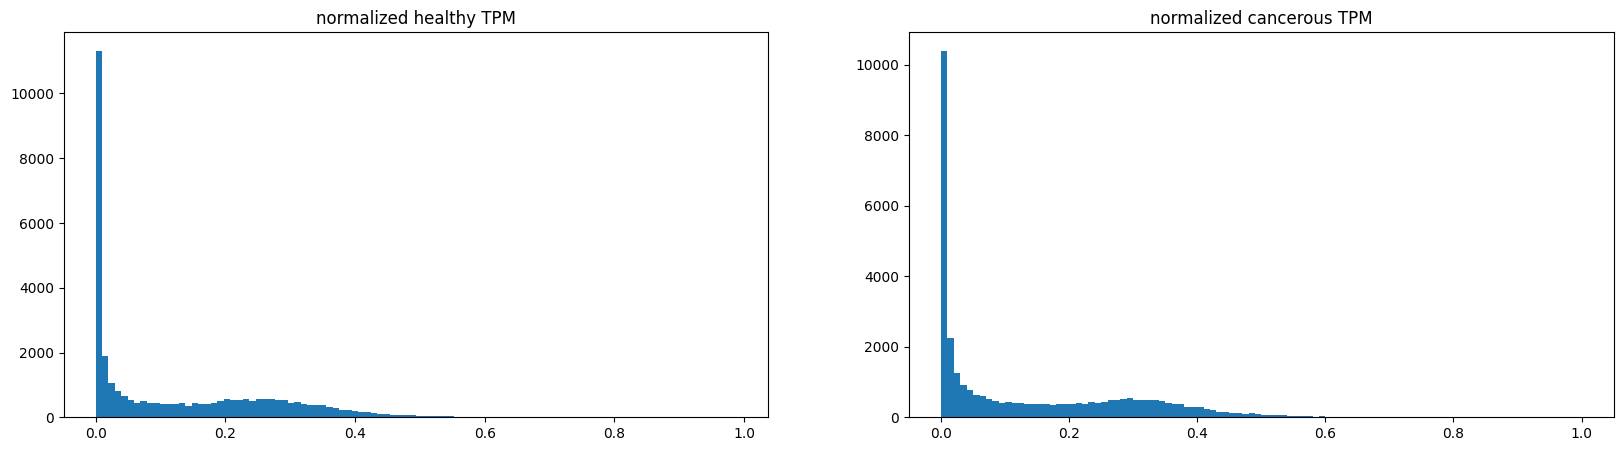

In [22]:
# healthy tpm
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(df_nodes_genes['norm healthy tpm'], bins=100)
plt.title('normalized healthy TPM')

# cmp tpm
plt.subplot(1, 2, 2)
plt.hist(df_nodes_genes['norm cancerous tpm'], bins=100)
plt.title('normalized cancerous TPM')

plt.show()

In [23]:
df_nodes_genes.drop(columns=['healthy tpm', 
                             'cancerous tpm'
                             ], inplace=True)
df_nodes_genes

,name,id,norm healthy tpm,norm cancerous tpm
0,A1BG,ENSG00000121410,0.220900,0.056729
1,A1BG-AS1,ENSG00000268895,0.119339,0.163408
2,A1CF,ENSG00000148584,0.057012,0.080626
3,A2M,ENSG00000175899,0.579917,0.092398
4,A2M-AS1,ENSG00000245105,0.162693,0.066802
...,...,...,...,...
32860,ZYG11AP1,ENSG00000232242,0.000057,0.000083
32861,ZYG11B,ENSG00000162378,0.252818,0.291435
32862,ZYXP1,ENSG00000274572,0.000010,0.000000
32863,ZZEF1,ENSG00000074755,0.280583,0.275600


## Calculate `delta tpm`

value of the difference between the normalized cancerous tpm and normalized healthy tpm

In [24]:
df_nodes_genes['delta tpm'] = df_nodes_genes['norm cancerous tpm'] - df_nodes_genes['norm healthy tpm']
df_nodes_genes['delta type'] = np.where(df_nodes_genes['delta tpm'] > 0, 'increase', 'decrease')

df_nodes_genes

,name,id,norm healthy tpm,norm cancerous tpm,delta tpm,delta type
0,A1BG,ENSG00000121410,0.220900,0.056729,-0.164171,decrease
1,A1BG-AS1,ENSG00000268895,0.119339,0.163408,0.044069,increase
2,A1CF,ENSG00000148584,0.057012,0.080626,0.023614,increase
3,A2M,ENSG00000175899,0.579917,0.092398,-0.487519,decrease
4,A2M-AS1,ENSG00000245105,0.162693,0.066802,-0.095891,decrease
...,...,...,...,...,...,...
32860,ZYG11AP1,ENSG00000232242,0.000057,0.000083,0.000026,increase
32861,ZYG11B,ENSG00000162378,0.252818,0.291435,0.038617,increase
32862,ZYXP1,ENSG00000274572,0.000010,0.000000,-0.000010,decrease
32863,ZZEF1,ENSG00000074755,0.280583,0.275600,-0.004983,decrease


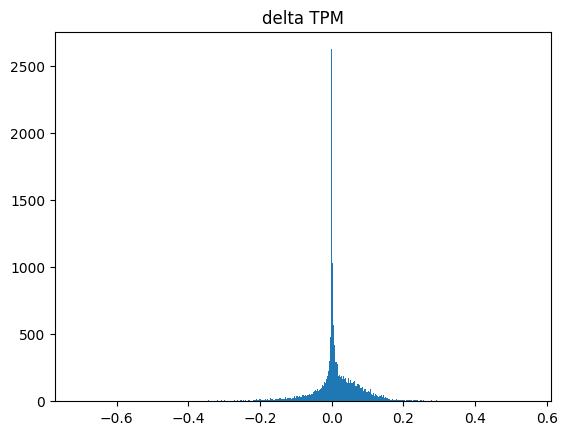

In [25]:
plt.hist(df_nodes_genes['delta tpm'], bins=1000)
plt.title('delta TPM')
plt.show()

In [26]:
# df_nodes_genes['delta tpm'] = np.abs(df_nodes_genes['delta tpm'])

## Calculate `delta_tpm_relevant` with z score
Add a column that indicates if the change in the gene activity is relevant between cancer and healthy tissue.


Z Score of the delta TPM values is calculated and used to determine if the gene is relevant for cancer.
This z score means how many standard deviations the delta tpm value is away from the mean.


In [27]:

df_nodes_genes['z score'] = zscore(df_nodes_genes['delta tpm'])

# 1.96 für die größten 5 % der Abweichungen
z_threshold = 1.96
df_nodes_genes['delta tpm relevant'] = df_nodes_genes['z score'].abs() > z_threshold

df_nodes_genes

,name,id,norm healthy tpm,norm cancerous tpm,delta tpm,delta type,z score,delta tpm relevant
0,A1BG,ENSG00000121410,0.220900,0.056729,-0.164171,decrease,-2.084790,True
1,A1BG-AS1,ENSG00000268895,0.119339,0.163408,0.044069,increase,0.438113,False
2,A1CF,ENSG00000148584,0.057012,0.080626,0.023614,increase,0.190296,False
3,A2M,ENSG00000175899,0.579917,0.092398,-0.487519,decrease,-6.002273,True
4,A2M-AS1,ENSG00000245105,0.162693,0.066802,-0.095891,decrease,-1.257556,False
...,...,...,...,...,...,...,...,...
32860,ZYG11AP1,ENSG00000232242,0.000057,0.000083,0.000026,increase,-0.095479,False
32861,ZYG11B,ENSG00000162378,0.252818,0.291435,0.038617,increase,0.372060,False
32862,ZYXP1,ENSG00000274572,0.000010,0.000000,-0.000010,decrease,-0.095916,False
32863,ZZEF1,ENSG00000074755,0.280583,0.275600,-0.004983,decrease,-0.156164,False


## Save

In [28]:
df_nodes_genes.to_csv('../processed_data/nodes_genes.csv', index=False)

In [29]:
print(f"There are {df_nodes_genes.shape[0]} rows as gene nodes.")

There are 32865 rows as gene nodes.
